# Project 3 - Solving PDEs using Physics Informed Neural Networks (PINNs)
## Grid search for hyperparameter settings
This notebook shows a selection of grid searches and randomized grid searches done for with the PINN-implementation based on ...


### Notebook initial imports and defaults

In [1]:
from networkFlow import *
from PDEq import *
from support import *

import autograd.numpy as anp
import numpy as np
from math import log10

import matplotlib.pyplot as plt

## Random seed
default_seed = 15; anp.random.seed(default_seed)

## Figure defaults
plt.rcParams["figure.figsize"] = (10,4); plt.rcParams["font.size"] = 10
cmap = 'hot_r'; bin_vals = 7

## --- Network initial defaults --- ##
## Collocation tensor parameters
c_points = 1000; b_points = 20; i_points = 20

## Activation function
hidden_func = 'swish' # sigmoid, relu, elu, leaky_relu, tanh, swish, gelu, hard_sigmoid, exponential

## Layer configuration
l_size = 20;
layer_out_sizes = [20,20,1]

act_funcs = []
for i in range(len(layer_out_sizes)-1):
    act_funcs.append(hidden_func)

## Output layer activation function set to identity
act_funcs.append(None);

## Training parameters
epoch = 1000
gd_method = 'adam'

## --- Search parameters --- ##
num = 6
rand_num = 60

## --- Problem setup --- ##
## Differential equations
test_cases = ['diff1d','wave1d','wave2d','diff2d']
test = test_cases[1]

## Coefficients
c,D,amplitude = 1.,1.,1.

if test == 'diff1d':
    PDE = Diffusion1D(sim_type='flow',amp=amplitude,D=D)
    t0,tN,x0,xN = 0,1,0,1
elif test == 'wave1d':
    PDE = Wave1D(sim_type='flow',amp=amplitude,c=c)
    t0,tN,x0,xN = 0,1,-1,1
elif test == 'wave2d':
    PDE = Wave2D(sim_type='flow',amp=amplitude,c=c)
    t0,tN = 0,1
    x0,xN,y0,yN = 0,1,0,1
elif test == 'diff2d':
    PDE = Diffusion2D(sim_type='flow',amp=amplitude,D=D)
    t0,tN = 0,1
    x0,xN,y0,yN = 0,1,0,1

## Defining the source function
f = PDE.right_hand_side

## Domain setup
Nt,Nx,Ny = 100,100,100

t_bound = [t0,tN]
x_bound = [x0,xN]

t = np.linspace(t_bound[0],t_bound[1],Nt)
x = np.linspace(x_bound[0],x_bound[1],Nx)

if test == 'wave2d' or test == 'diff2d':
    y_bound = [y0,yN]
    y = np.linspace(y_bound[0],y_bound[1],Ny)
    domain_array = np.array([t,x,y])
else:
    domain_array = np.array([t,x])

## Regular grid search
### Learning rate, $\eta$, vs. regularization, $\lambda$
A grid search comparing the learning rate and regularization of the parameters of the network. Here, gradient descent is performed using the `Adagrad`-method-

In [3]:
## Training parameters
eta = np.logspace(-3,-1,num)
lmbda = np.logspace(-9,-7,num)

cost = np.zeros((len(eta),len(lmbda)))

for i in range(len(eta)):
    for j in range(len(lmbda)):
        ## Network initializtion
        if test == 'wave2d' or test == 'diff2d':
            TFNetwork = FFNNetworkFlow2D(layer_output_size=layer_out_sizes,
                           activation_functions=act_funcs,
                           PDE=PDE,
                           source_function=f,
                           domain_array=domain_array,
                           domain=[x_bound,y_bound],
                           gd_method=gd_method,
                           learning_rate=eta[i])

            ## Setup of collocation tensor
            TFNetwork.collocation_setup(bounds=(t_bound,x_bound,y_bound), colloc_points=c_points,
                            bound_points=b_points, init_points=i_points)
        else:
            TFNetwork = FFNNetworkFlow(layer_output_size=layer_out_sizes,
                            activation_functions=act_funcs,
                            PDE=PDE,
                            source_function=f,
                            domain_array=domain_array,
                            domain=x_bound,
                            gd_method=gd_method,
                            learning_rate=eta[i])

            ## Setup of collocation tensor
            TFNetwork.collocation_setup(bounds=(x_bound,t_bound), colloc_points=c_points,
                                    bound_points=b_points, init_points=i_points,
                                    plot_colloc=False)

        TFNetwork.create_layers(lmbda=lmbda[j])

        print('η,λ = %.2e, %.2e' %(eta[i],lmbda[j]))
        TFNetwork.train_network(epochs=epoch)

        cost[i,j] = TFNetwork.cost_history[-1]

η,λ = 1.00e-03, 1.00e-09
Final cost = 6.87289e-03
η,λ = 1.00e-03, 2.51e-09
Final cost = 8.08835e-03
η,λ = 1.00e-03, 6.31e-09
Final cost = 7.51975e-03
η,λ = 1.00e-03, 1.58e-08
Final cost = 7.74407e-03
η,λ = 1.00e-03, 3.98e-08
Final cost = 8.11204e-03
η,λ = 1.00e-03, 1.00e-07
Final cost = 6.84943e-03
η,λ = 2.51e-03, 1.00e-09
Final cost = 6.30106e-03
η,λ = 2.51e-03, 2.51e-09
Final cost = 6.18749e-03
η,λ = 2.51e-03, 6.31e-09
Final cost = 6.30825e-03
η,λ = 2.51e-03, 1.58e-08
Final cost = 6.26448e-03
η,λ = 2.51e-03, 3.98e-08
Final cost = 7.21496e-03
η,λ = 2.51e-03, 1.00e-07
Final cost = 6.01029e-03
η,λ = 6.31e-03, 1.00e-09
Final cost = 5.56218e-03
η,λ = 6.31e-03, 2.51e-09
Final cost = 5.63542e-03
η,λ = 6.31e-03, 6.31e-09
Final cost = 5.13426e-03
η,λ = 6.31e-03, 1.58e-08
Final cost = 6.38242e-03
η,λ = 6.31e-03, 3.98e-08
Final cost = 6.40192e-03
η,λ = 6.31e-03, 1.00e-07
Final cost = 4.99169e-03
η,λ = 1.58e-02, 1.00e-09
Final cost = 4.02110e-03
η,λ = 1.58e-02, 2.51e-09
Final cost = 1.12471e-02


Min cost for:
η = 1.000e-01
λ = 6.310e-09
Final cost = 3.58046e-03


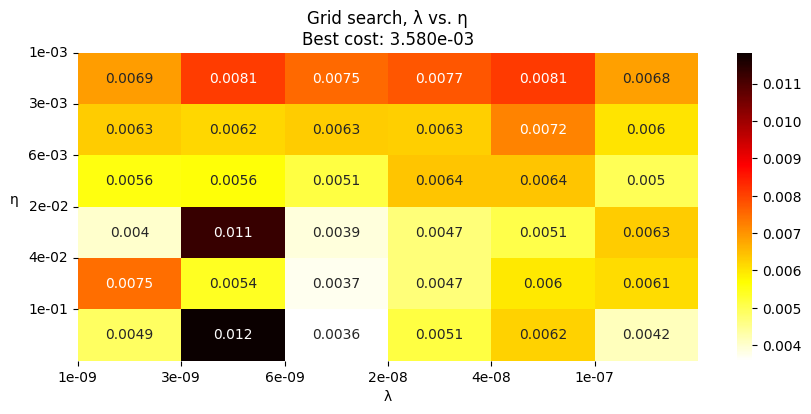

In [6]:
fig,ax = lambda_eta(cost,[lmbda,eta],
                    axis_tick_labels=[[f'{y:.0e}' for y in lmbda],[f'{y:.0e}' for y in eta]],
                    cbar_lim=[cost.min(),cost.max()],cmap=cmap
                    )

fig.set_size_inches(10,4)

min_cost_idx = np.argmin(cost); min_cost_pos = np.unravel_index(min_cost_idx, cost.shape)
ax.set_title('Grid search, λ vs. η\nBest cost: %.3e' %cost[min_cost_pos])

print('Min cost for:\nη = %.3e\nλ = %.3e'%(eta[min_cost_pos[0]],lmbda[min_cost_pos[1]]))
print('Final cost = %.5e' %cost[min_cost_pos])

## Randomized grid searchs
The following part performs a randomized grid search for the optimal hyperparameters for the chosen PDE-problem.

It does searches of random combinations of learning rate, $\eta$, regularization, $\lambda$, epochs, $e$, network depth, $d$, and hidden layer width, $M$.

The ranges currently set up in the cells below are ranges that was found to give good results for the chosen PDE-problem.
### Search: Learning rate, $\eta$, vs. regularization, $\lambda$

In [7]:
## Search parameters
eta_range = [1e-3,1e-1]
lmbda_range = [1e-9,1e-7]

cost = np.zeros(rand_num)
etas = np.zeros_like(cost)
lmbdas = np.zeros_like(etas)

for i in range(rand_num):
    ## Picking parameters from uniform distribution
    eta = 10 ** np.random.uniform(log10(eta_range[0]), log10(eta_range[1])); etas[i] = eta
    lmbda = 10 ** np.random.uniform(log10(lmbda_range[0]), log10(lmbda_range[1])); lmbdas[i] = lmbda

    ## Network initializtion
    if test == 'wave2d' or test == 'diff2d':
        TFNetwork = FFNNetworkFlow2D(layer_output_size=layer_out_sizes,
                           activation_functions=act_funcs,
                           PDE=PDE,
                           source_function=f,
                           domain_array=domain_array,
                           domain=[x_bound,y_bound],
                           gd_method=gd_method,
                           learning_rate=eta)

        ## Setup of collocation tensor
        TFNetwork.collocation_setup(bounds=(t_bound,x_bound,y_bound), colloc_points=c_points,
                            bound_points=b_points, init_points=i_points)
    else:
        TFNetwork = FFNNetworkFlow(layer_output_size=layer_out_sizes,
                            activation_functions=act_funcs,
                            PDE=PDE,
                            source_function=f,
                            domain_array=domain_array,
                            domain=x_bound,
                            gd_method=gd_method,
                            learning_rate=eta)

        ## Setup of collocation tensor
        TFNetwork.collocation_setup(bounds=(x_bound,t_bound), colloc_points=c_points,
                                    bound_points=b_points, init_points=i_points,
                                    plot_colloc=False)

    TFNetwork.create_layers(lmbda=lmbda)

    print('η, λ = %.2e, %.2e' %(eta,lmbda))
    TFNetwork.train_network(epochs=epoch)

    #cost.append(TFNetwork.cost_history[-1])
    cost[i] = TFNetwork.cost_history[-1]

η, λ = 1.51e-02, 4.50e-08
Final cost = 5.42447e-03
η, λ = 4.49e-03, 1.85e-09
Final cost = 4.93967e-03
η, λ = 2.13e-02, 2.92e-08
Final cost = 6.12438e-03
η, λ = 2.13e-03, 9.27e-09
Final cost = 4.92658e-03
η, λ = 1.15e-03, 1.90e-08
Final cost = 8.90282e-03
η, λ = 1.27e-03, 4.79e-09
Final cost = 8.52534e-03
η, λ = 3.41e-02, 8.46e-09
Final cost = 8.07682e-03
η, λ = 3.48e-02, 3.83e-08
Final cost = 3.34735e-03
η, λ = 3.45e-03, 1.12e-09
Final cost = 6.25695e-03
η, λ = 4.16e-03, 1.76e-08
Final cost = 5.79916e-03
η, λ = 1.10e-02, 2.34e-08
Final cost = 5.90186e-03
η, λ = 2.10e-02, 1.27e-08
Final cost = 5.94247e-03
η, λ = 8.76e-03, 1.35e-09
Final cost = 5.12861e-03
η, λ = 3.55e-02, 8.48e-08
Final cost = 5.31401e-03
η, λ = 5.06e-03, 1.62e-08
Final cost = 4.78969e-03
η, λ = 5.64e-02, 1.80e-09
Final cost = 5.19288e-03
η, λ = 3.90e-03, 1.37e-08
Final cost = 5.40927e-03
η, λ = 1.72e-02, 5.56e-09
Final cost = 4.42158e-03
η, λ = 3.72e-03, 8.78e-09
Final cost = 4.52403e-03
η, λ = 1.01e-03, 1.39e-09
Final

/content/support.py:372: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  ax.add_patch(plt.Rectangle((j, i), 1, 1, color='1', edgecolor='none'))


Min cost for:
η = 3.484e-02
λ = 3.834e-08
Final cost = 3.34735e-03


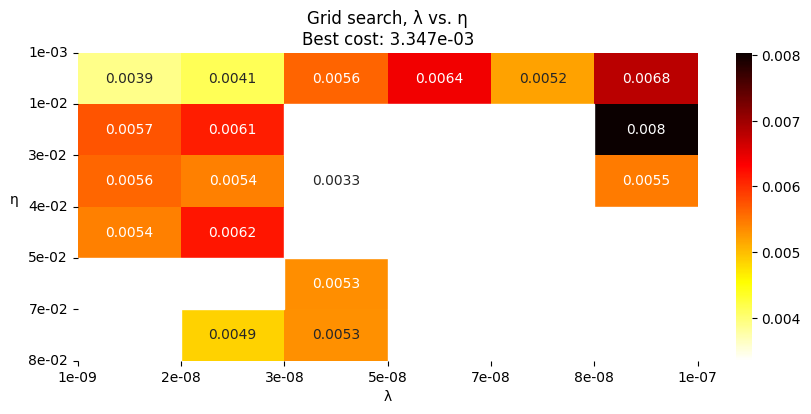

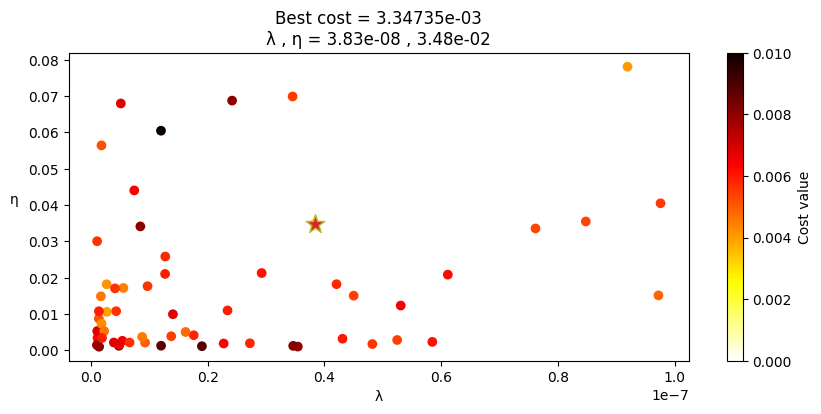

In [9]:
fig_h,ax_h = rand_heatmap(cost,[lmbdas,etas],
             axis_tick_labels='scientific',axis_labels=['λ','η'],
             bin_vals=bin_vals,cmap=cmap,
             cbar_lim=[cost.min(),cost.max()]
             )

fig_s,ax_s = rand_scatter(cost,[lmbdas,etas],axis_labels=['λ','η'],cmap=cmap,cbar_lim=[0.,0.01])

fig_h.set_size_inches(10,4)
fig_s.set_size_inches(10,4)

min_cost_idx = cost.argmin()

ax_h.set_title('Grid search, λ vs. η\nBest cost: %.3e' %cost[min_cost_idx])
print('Min cost for:\nη = %.3e\nλ = %.3e'%(etas[min_cost_idx],lmbdas[min_cost_idx]))
print('Final cost = %.5e' %cost[min_cost_idx])

### Search: Network depth, $d$, vs. hidden layer size, $M$

In [10]:
## Restating training parameters
eta = 1e-2
lmbda = 1e-8

## Search parameters
d_range = [1,6]
M_range = [1,50]

cost = np.zeros(rand_num)
d = np.zeros(rand_num)
M = np.zeros(rand_num)

for i in range(rand_num):
    ## Setting random parameters
    l_size = np.random.randint(M_range[0],M_range[1]); M[i] = l_size
    num_lay = np.random.randint(d_range[0],d_range[1]); d[i] = num_lay

    act_funcs = []; layer_out_sizes = [1]
    for _ in range(num_lay):
        layer_out_sizes = [l_size] + layer_out_sizes
        act_funcs.append(hidden_func)

    ## Output layer activation function set to identity
    act_funcs.append(None);

    ## Network initializtion
    if test == 'wave2d' or test == 'diff2d':
        TFNetwork = FFNNetworkFlow2D(layer_output_size=layer_out_sizes,
                           activation_functions=act_funcs,
                           PDE=PDE,
                           source_function=f,
                           domain_array=domain_array,
                           domain=[x_bound,y_bound],
                           gd_method=gd_method,
                           learning_rate=eta)

        ## Setup of collocation tensor
        TFNetwork.collocation_setup(bounds=(t_bound,x_bound,y_bound), colloc_points=c_points,
                            bound_points=b_points, init_points=i_points)
    else:
        TFNetwork = FFNNetworkFlow(layer_output_size=layer_out_sizes,
                            activation_functions=act_funcs,
                            PDE=PDE,
                            source_function=f,
                            domain_array=domain_array,
                            domain=x_bound,
                            gd_method=gd_method,
                            learning_rate=eta)

        ## Setup of collocation tensor
        TFNetwork.collocation_setup(bounds=(x_bound,t_bound), colloc_points=c_points,
                                    bound_points=b_points, init_points=i_points,
                                    plot_colloc=False)

    TFNetwork.create_layers(lmbda=lmbda)

    print('d, M = %i, %i' %(num_lay,l_size))
    TFNetwork.train_network(epochs=epoch)

    #cost.append(TFNetwork.cost_history[-1])
    cost[i] = TFNetwork.cost_history[-1]

d, M = 4, 27
Final cost = 5.52137e-03
d, M = 3, 4
Final cost = 6.82775e-03
d, M = 5, 18
Final cost = 5.35156e-03
d, M = 2, 28
Final cost = 5.25082e-03
d, M = 4, 11
Final cost = 2.96774e-03
d, M = 5, 23
Final cost = 6.67326e-03
d, M = 1, 24
Final cost = 6.88038e-03
d, M = 1, 21
Final cost = 6.99485e-03
d, M = 3, 2
Final cost = 2.32355e-02
d, M = 4, 41
Final cost = 5.50472e-03
d, M = 2, 17
Final cost = 4.05430e-03
d, M = 5, 23
Final cost = 4.22127e-03
d, M = 5, 16
Final cost = 5.86909e-03
d, M = 5, 38
Final cost = 6.23156e-03
d, M = 3, 44
Final cost = 5.05303e-03
d, M = 2, 46
Final cost = 4.35855e-03
d, M = 4, 47
Final cost = 4.61643e-03
d, M = 4, 35
Final cost = 5.92383e-03
d, M = 1, 38
Final cost = 7.40693e-03
d, M = 5, 16
Final cost = 7.22458e-03
d, M = 1, 11
Final cost = 6.94603e-03
d, M = 2, 19
Final cost = 5.25661e-03
d, M = 1, 48
Final cost = 5.22581e-03
d, M = 1, 42
Final cost = 6.72273e-03
d, M = 2, 40
Final cost = 6.11834e-03
d, M = 1, 12
Final cost = 6.22126e-03
d, M = 5, 4
Fi

/content/support.py:372: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  ax.add_patch(plt.Rectangle((j, i), 1, 1, color='1', edgecolor='none'))


Min cost for:
d = 4
M = 11
Final cost = 2.96774e-03


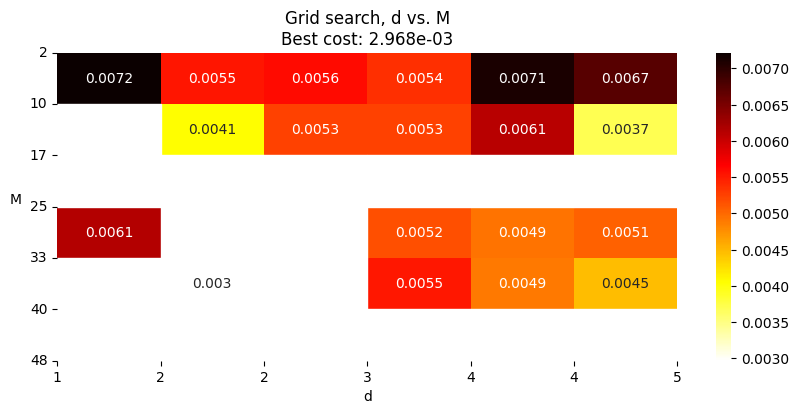

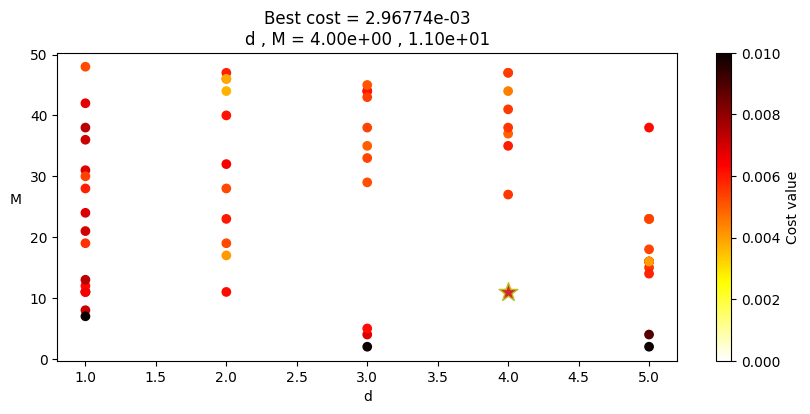

In [12]:
fig_h,ax_h = rand_heatmap(cost,[d,M],
             axis_tick_labels='float',axis_labels=['d','M'],
             bin_vals=bin_vals,cmap=cmap,
             cbar_lim=[cost.min(),cost.max()]
             )

fig_s,ax_s = rand_scatter(cost,[d,M],axis_labels=['d','M'],cmap=cmap,cbar_lim=[0.,0.01])

#fig_h.set_size_inches(10,4)
#fig_s.set_size_inches(10,4)

min_cost_idx = cost.argmin()

ax_h.set_title('Grid search, d vs. M\nBest cost: %.3e' %cost[min_cost_idx])
print('Min cost for:\nd = %i\nM = %i'%(d[min_cost_idx],M[min_cost_idx]))
print('Final cost = %.5e' %cost[min_cost_idx])

### Search: Learning rate, $\eta$, vs. number of epochs, $e$

In [13]:
## Restating network structure parameters
layer_out_sizes = [20,20,1]
act_funcs = []
for i in range(len(layer_out_sizes)-1):
    act_funcs.append(hidden_func)
act_funcs.append(None)

## Search parameters
eta_range = [1e-3,1e-1]
epoch_range = [10,4000]

cost = np.zeros(rand_num)
etas = np.zeros_like(cost)
epochs = np.zeros_like(etas)

for i in range(rand_num):
    ## Picking random parameters
    eta = 10 ** np.random.uniform(log10(eta_range[0]), log10(eta_range[1])); etas[i] = eta
    epoch = np.random.randint(epoch_range[0],epoch_range[1]); epochs[i] = epoch

    ## Network initializtion
    if test == 'wave2d' or test == 'diff2d':
        TFNetwork = FFNNetworkFlow2D(layer_output_size=layer_out_sizes,
                           activation_functions=act_funcs,
                           PDE=PDE,
                           source_function=f,
                           domain_array=domain_array,
                           domain=[x_bound,y_bound],
                           gd_method=gd_method,
                           learning_rate=eta)

        ## Setup of collocation tensor
        TFNetwork.collocation_setup(bounds=(t_bound,x_bound,y_bound), colloc_points=c_points,
                            bound_points=b_points, init_points=i_points)
    else:
        TFNetwork = FFNNetworkFlow(layer_output_size=layer_out_sizes,
                            activation_functions=act_funcs,
                            PDE=PDE,
                            source_function=f,
                            domain_array=domain_array,
                            domain=x_bound,
                            gd_method=gd_method,
                            learning_rate=eta)

        ## Setup of collocation tensor
        TFNetwork.collocation_setup(bounds=(x_bound,t_bound), colloc_points=c_points,
                                    bound_points=b_points, init_points=i_points,
                                    plot_colloc=False)

    TFNetwork.create_layers(lmbda=lmbda)

    print('η, e = %.3e, %i' %(eta,epoch))
    TFNetwork.train_network(epochs=epoch)

    #cost.append(TFNetwork.cost_history[-1])
    cost[i] = TFNetwork.cost_history[-1]

η, e = 1.029e-03, 121
Final cost = 2.55680e-01
η, e = 2.765e-02, 1617
Final cost = 4.46008e-03
η, e = 1.415e-03, 974
Final cost = 6.60781e-03
η, e = 3.196e-02, 2912
Final cost = 4.89079e-04
η, e = 4.214e-02, 2595
Final cost = 2.76862e-04
η, e = 7.325e-02, 1780
Final cost = 6.92687e-03
η, e = 1.858e-02, 1215
Final cost = 4.13953e-03
η, e = 3.270e-03, 2044
Final cost = 4.44407e-03
η, e = 3.202e-02, 2935
Final cost = 4.14156e-03
η, e = 5.422e-03, 2638
Final cost = 5.24015e-03
η, e = 2.199e-02, 2207
Final cost = 4.33088e-03
η, e = 9.601e-02, 3556
Final cost = 5.82396e-04
η, e = 2.463e-02, 2409
Final cost = 4.34741e-03
η, e = 4.584e-03, 817
Final cost = 5.08232e-03
η, e = 4.480e-03, 40
Final cost = 3.95912e-01
η, e = 6.654e-02, 1443
Final cost = 4.80745e-03
η, e = 1.823e-02, 2132
Final cost = 4.27402e-03
η, e = 6.899e-02, 1689
Final cost = 2.10888e-03
η, e = 1.840e-02, 3995
Final cost = 2.22584e-03
η, e = 3.925e-03, 2405
Final cost = 5.47966e-03
η, e = 1.681e-03, 2336
Final cost = 5.09328e-

/content/support.py:372: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  ax.add_patch(plt.Rectangle((j, i), 1, 1, color='1', edgecolor='none'))


Min cost for:
η = 4.214e-02
e = 2595
Final cost = 2.76862e-04


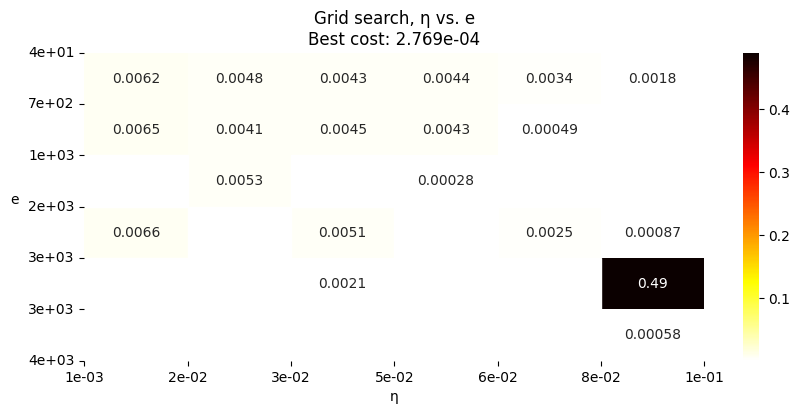

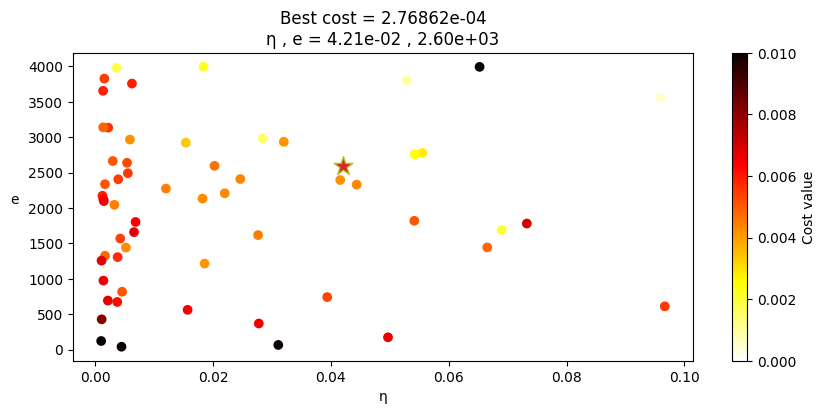

In [15]:
fig_h,ax_h = rand_heatmap(cost,[etas,epochs],
             axis_tick_labels='scientific',axis_labels=['η','e'],
             bin_vals=bin_vals,cmap=cmap,
             cbar_lim=[0.,0.01]
             )

fig_s,ax_s = rand_scatter(cost,[etas,epochs],axis_labels=['η','e'],cbar_lim=[0.,0.01],cmap=cmap)

#fig_h.set_size_inches(10,4)
#fig_s.set_size_inches(10,4)

min_cost_idx = cost.argmin()
ax_h.set_title('Grid search, η vs. e\nBest cost: %.3e' %cost[min_cost_idx])
print('Min cost for:\nη = %.3e\ne = %i'%(etas[min_cost_idx],epochs[min_cost_idx]))
print('Final cost = %.5e' %cost[min_cost_idx])

### Search: Learning rate, $\eta$ vs., network depth, $d$

In [16]:
## Restating training parameters
epoch = 1000

## Search parameters
eta_range = [1e-3,1e-1]
d_range = [1,6]

cost = np.zeros(rand_num)
etas = np.zeros(rand_num)
d = np.zeros(rand_num)

for i in range(rand_num):
    eta = 10 ** np.random.uniform(log10(eta_range[0]), log10(eta_range[1])); etas[i] = eta

    num_lay = np.random.randint(d_range[0],d_range[1]); d[i] = num_lay

    act_funcs = []; layer_out_sizes = [1]
    for _ in range(num_lay):
        layer_out_sizes = [l_size] + layer_out_sizes
        act_funcs.append(hidden_func)

    ## Output layer activation function set to identity
    act_funcs.append(None);

    ## Network initializtion
    if test == 'wave2d' or test == 'diff2d':
        TFNetwork = FFNNetworkFlow2D(layer_output_size=layer_out_sizes,
                           activation_functions=act_funcs,
                           PDE=PDE,
                           source_function=f,
                           domain_array=domain_array,
                           domain=[x_bound,y_bound],
                           gd_method=gd_method,
                           learning_rate=eta)

        ## Setup of collocation tensor
        TFNetwork.collocation_setup(bounds=(t_bound,x_bound,y_bound), colloc_points=c_points,
                            bound_points=b_points, init_points=i_points)
    else:
        TFNetwork = FFNNetworkFlow(layer_output_size=layer_out_sizes,
                            activation_functions=act_funcs,
                            PDE=PDE,
                            source_function=f,
                            domain_array=domain_array,
                            domain=x_bound,
                            gd_method=gd_method,
                            learning_rate=eta)

        ## Setup of collocation tensor
        TFNetwork.collocation_setup(bounds=(x_bound,t_bound), colloc_points=c_points,
                                    bound_points=b_points, init_points=i_points,
                                    plot_colloc=False)

    TFNetwork.create_layers(lmbda=lmbda)

    print('η, d = %.3e, %i' %(eta,num_lay))
    TFNetwork.train_network(epochs=epoch)

    #cost.append(TFNetwork.cost_history[-1])
    cost[i] = TFNetwork.cost_history[-1]

η, d = 3.276e-03, 4
Final cost = 5.50934e-03
η, d = 3.048e-02, 5
Final cost = 9.34910e-03
η, d = 1.737e-03, 4
Final cost = 6.19381e-03
η, d = 8.997e-03, 4
Final cost = 1.82767e-03
η, d = 2.119e-03, 1
Final cost = 9.59968e-03
η, d = 2.758e-02, 4
Final cost = 4.73242e-03
η, d = 1.322e-03, 4
Final cost = 5.13042e-03
η, d = 3.483e-03, 5
Final cost = 4.36486e-03
η, d = 1.335e-02, 3
Final cost = 6.74403e-03
η, d = 2.224e-03, 4
Final cost = 3.20215e-03
η, d = 6.301e-02, 1
Final cost = 6.63982e-03
η, d = 1.448e-03, 2
Final cost = 5.94022e-03
η, d = 6.112e-03, 3
Final cost = 5.45064e-03
η, d = 5.723e-02, 4
Final cost = 4.32455e-03
η, d = 9.160e-03, 1
Final cost = 7.10235e-03
η, d = 2.946e-03, 4
Final cost = 5.20674e-03
η, d = 1.314e-02, 5
Final cost = 5.24922e-03
η, d = 2.085e-02, 3
Final cost = 4.08277e-03
η, d = 2.041e-02, 5
Final cost = 7.06021e-03
η, d = 1.016e-02, 1
Final cost = 6.15324e-03
η, d = 5.752e-02, 1
Final cost = 4.46348e-03
η, d = 5.603e-03, 1
Final cost = 8.17007e-03
η, d = 5.8

/content/support.py:372: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  ax.add_patch(plt.Rectangle((j, i), 1, 1, color='1', edgecolor='none'))


Min cost for:
η = 8.997e-03
d = 4
Final cost = 1.82767e-03


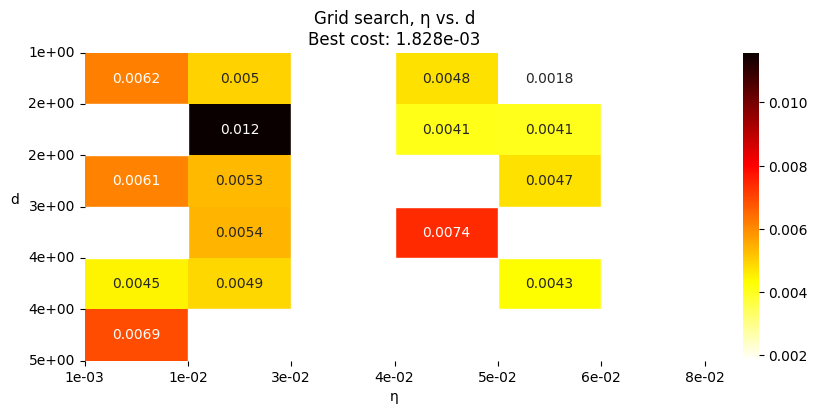

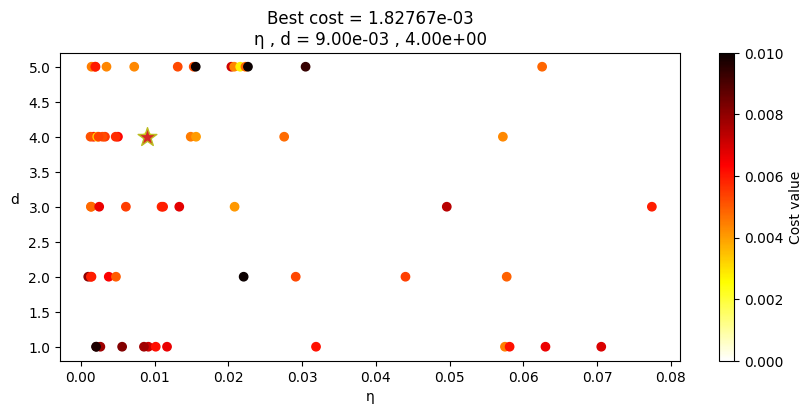

In [18]:
fig_h,ax_h = rand_heatmap(cost,[etas,d],
             axis_tick_labels='scientific',axis_labels=['η','d'],
             bin_vals=bin_vals,cmap=cmap,
             cbar_lim=[cost.min(),cost.max()]
             )

fig_s,ax_s = rand_scatter(cost,[etas,d],cmap=cmap,cbar_lim=[0.,0.01],axis_labels=['η','d'])

fig_h.set_size_inches(10,4)
fig_s.set_size_inches(10,4)

min_cost_idx = cost.argmin()
ax_h.set_title('Grid search, η vs. d\nBest cost: %.3e' %cost[min_cost_idx])
print('Min cost for:\nη = %.3e\nd = %i'%(etas[min_cost_idx],d[min_cost_idx]))
print('Final cost = %.5e' %cost[min_cost_idx])


### Search: Learning rate, $\eta$ vs. hidden layer width, $M$

In [20]:
## Restating network parameters
num_lay = 2

## Search parameters
eta_range = [1e-3,1e-1]
M_range = [1,50]

cost = np.zeros(rand_num)
etas = np.zeros(rand_num)
M = np.zeros(rand_num)

for i in range(rand_num):
    ## Picking random parameters
    l_size = np.random.randint(M_range[0],M_range[1]); M[i] = l_size
    eta = 10 ** np.random.uniform(log10(eta_range[0]), log10(eta_range[1])); etas[i] = eta

    act_funcs = []; layer_out_sizes = [1]
    for _ in range(num_lay):
        layer_out_sizes = [l_size] + layer_out_sizes
        act_funcs.append(hidden_func)
    act_funcs.append(None);

    ## Network initializtion
    if test == 'wave2d' or test == 'diff2d':
        TFNetwork = FFNNetworkFlow2D(layer_output_size=layer_out_sizes,
                           activation_functions=act_funcs,
                           PDE=PDE,
                           source_function=f,
                           domain_array=domain_array,
                           domain=[x_bound,y_bound],
                           gd_method=gd_method,
                           learning_rate=eta)

        ## Setup of collocation tensor
        TFNetwork.collocation_setup(bounds=(t_bound,x_bound,y_bound), colloc_points=c_points,
                            bound_points=b_points, init_points=i_points)
    else:
        TFNetwork = FFNNetworkFlow(layer_output_size=layer_out_sizes,
                            activation_functions=act_funcs,
                            PDE=PDE,
                            source_function=f,
                            domain_array=domain_array,
                            domain=x_bound,
                            gd_method=gd_method,
                            learning_rate=eta)

        ## Setup of collocation tensor
        TFNetwork.collocation_setup(bounds=(x_bound,t_bound), colloc_points=c_points,
                                    bound_points=b_points, init_points=i_points,
                                    plot_colloc=False)

    TFNetwork.create_layers(lmbda=lmbda)

    print('η, M = %.3e, %i' %(eta,l_size))
    TFNetwork.train_network(epochs=epoch)

    #cost.append(TFNetwork.cost_history[-1])
    cost[i] = TFNetwork.cost_history[-1]

η, M = 2.711e-03, 32
Final cost = 6.29202e-03
η, M = 2.973e-03, 48
Final cost = 6.60007e-03
η, M = 8.599e-02, 36
Final cost = 4.81686e-03
η, M = 1.144e-03, 45
Final cost = 8.15228e-03
η, M = 4.012e-03, 6
Final cost = 6.24790e-03
η, M = 2.093e-03, 43
Final cost = 5.79323e-03
η, M = 2.350e-03, 26
Final cost = 6.52539e-03
η, M = 1.108e-02, 49
Final cost = 6.00529e-03
η, M = 1.600e-02, 16
Final cost = 5.59264e-03
η, M = 4.503e-03, 4
Final cost = 6.71970e-03
η, M = 9.950e-03, 9
Final cost = 4.23265e-03
η, M = 2.187e-02, 4
Final cost = 4.06493e-03
η, M = 6.362e-03, 21
Final cost = 5.16128e-03
η, M = 5.808e-03, 44
Final cost = 5.05220e-03
η, M = 6.279e-02, 15
Final cost = 4.36346e-03
η, M = 1.724e-02, 25
Final cost = 5.60061e-03
η, M = 2.585e-03, 16
Final cost = 5.72716e-03
η, M = 3.474e-03, 34
Final cost = 4.75738e-03
η, M = 6.920e-03, 20
Final cost = 5.91468e-03
η, M = 1.517e-02, 22
Final cost = 4.31690e-03
η, M = 4.316e-03, 43
Final cost = 5.78801e-03
η, M = 5.994e-02, 13
Final cost = 5.54

/content/support.py:372: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  ax.add_patch(plt.Rectangle((j, i), 1, 1, color='1', edgecolor='none'))


Min cost for:
η = 2.187e-02
M = 4
Final cost = 4.06493e-03


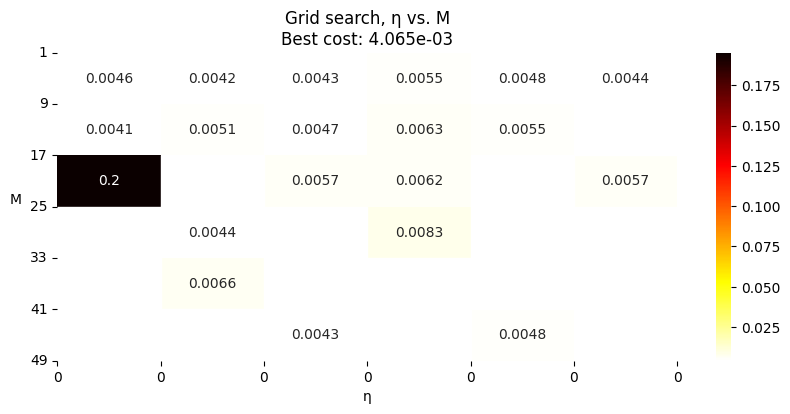

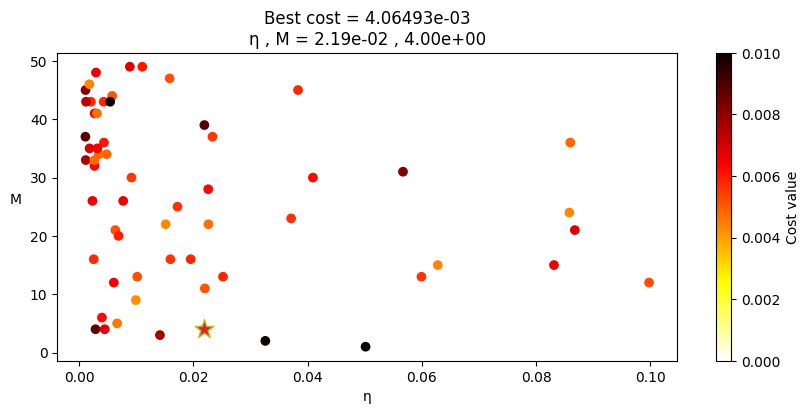

In [21]:
fig_h,ax_h = rand_heatmap(cost,[etas,M],
             axis_tick_labels='float',axis_labels=['η','M'],
             bin_vals=bin_vals,cmap=cmap,
             cbar_lim=[cost.min(),cost.max()]
             )

fig_s,ax_s = rand_scatter(cost,[etas,M],cmap=cmap,cbar_lim=[0.,0.01],axis_labels=['η','M'])

#fig_h.set_size_inches(10,4)
#fig_s.set_size_inches(10,4)

min_cost_idx = cost.argmin()
ax_h.set_title('Grid search, η vs. M\nBest cost: %.3e' %cost[min_cost_idx])
print('Min cost for:\nη = %.3e\nM = %i'%(etas[min_cost_idx],M[min_cost_idx]))
print('Final cost = %.5e' %cost[min_cost_idx])